# Setup

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"
from sacred.observers import MongoObserver
import pickle as pkl
from addict import Dict
from sklearn.pipeline import Pipeline
import clinical_text_analysis as cta
import pandas as pd
import numpy as np
import random
from os import path
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# tf.enable_eager_execution()
import data_reader as read
import util_funcs
import string

from addict import Dict
import sacred
import preprocessingV2.preprocessingV2 as ppv2
from keras_models.metrics import f1, sensitivity, specificity, auc
from sklearn.metrics import f1_score, roc_auc_score, classification_report


Using TensorFlow backend.


In [2]:
def read_tfrecord(example):
    features = { \
               'data':  tf.io.FixedLenFeature([21*1000], tf.float32,),\
               'label':  tf.io.FixedLenFeature([1], tf.int64,),\
               'subtypeLabel':  tf.io.FixedLenFeature([1], tf.int64,),\
               'session':  tf.io.FixedLenFeature([1], tf.int64,), \
               'montage':  tf.io.FixedLenFeature([22], tf.int64,)}

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)

    # del example
    return data, tf.one_hot(class_label[0], 2)

In [18]:

def get_batched_dataset(filenames, batch_size, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_positive_train_dataset(filenames,  max_queue_size=5, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(tf.cast(y, tf.int32), 0), 1))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
   
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(tf.cast(y, tf.int32), 0), 0))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)   
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)

In [20]:
batch_size=64
# train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [4]:
taken = train_data.take(10)
caught = []
taken = taken.make_one_shot_iterator()
for val in taken:
    caught.append(val[1])

TypeError: 'Iterator' object is not iterable

In [ ]:
caught[0][0]

In [ ]:
taken = valid_data.take(10)
valid_caught = []
taken = taken.make_one_shot_iterator()
for val in taken:
    valid_caught.append(val)

In [ ]:
caught[0][1]

In [21]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    tf.keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[auc])

In [2]:
num_train = 0
for record in tf.python_io.tf_record_iterator("/n/scratch2/ms994/train_4s.tfr"):
     num_train += 1
num_valid = 0
for record in tf.python_io.tf_record_iterator("/n/scratch2/ms994/valid_4s.tfr"):
     num_valid += 1
num_test = 0
for record in tf.python_io.tf_record_iterator("/n/scratch2/ms994/test_4s.tfr"):
     num_test += 1

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [3]:
num_train, num_valid, num_test

(203894, 81251, 129670)

In [13]:
num_cnn_layers = 4
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer
for i in range(num_cnn_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.Conv2D(4, (3,3))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, name="seizure", activation="softmax")(x)
model = tf.keras.Model(inputs=inputLayer, outputs=x)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1000, 21, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 998, 19, 4)        40        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 998, 19, 4)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 499, 19, 4)        0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 499, 19, 4)        16        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 497, 17, 4)        148       
__________

In [15]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy", f1, sensitivity, specificity])

In [ ]:
int(num_valid/batch_size)

In [16]:
batch_size=64
history = model.fit(train_data, steps_per_epoch=(600), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode="max", patience=10)])

Epoch 1/100
600/600 [==============================] - 69s 115ms/step - loss: 0.9317 - acc: 0.5301 - f1: 0.0628 - sensitivity: 0.1723 - specificity: 0.9628 - val_loss: 0.7330 - val_acc: 0.4527 - val_f1: 0.0586 - val_sensitivity: 0.1328 - val_specificity: 0.9608
Epoch 2/100
600/600 [==============================] - 55s 91ms/step - loss: 0.7399 - acc: 0.6163 - f1: 0.0468 - sensitivity: 0.1774 - specificity: 0.9735 - val_loss: 0.5047 - val_acc: 0.8882 - val_f1: 0.0261 - val_sensitivity: 0.0230 - val_specificity: 0.9632
Epoch 3/100
600/600 [==============================] - 55s 91ms/step - loss: 0.5944 - acc: 0.7016 - f1: 0.0516 - sensitivity: 0.1427 - specificity: 0.9704 - val_loss: 0.5202 - val_acc: 0.8478 - val_f1: 0.0643 - val_sensitivity: 0.0703 - val_specificity: 0.9255
Epoch 4/100
600/600 [==============================] - 55s 91ms/step - loss: 0.5065 - acc: 0.7575 - f1: 0.0578 - sensitivity: 0.1066 - specificity: 0.9576 - val_loss: 0.3829 - val_acc: 0.9452 - val_f1: 0.0119 - val_s

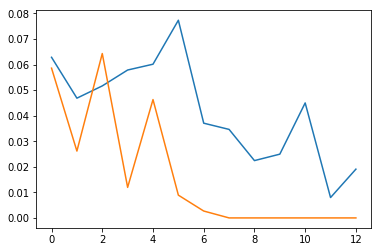

In [23]:
import matplotlib.pyplot as plt
from addict import Dict
history = Dict(history.history)

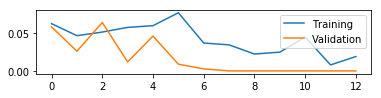

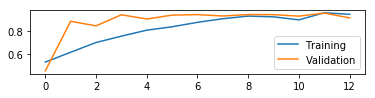

In [28]:
from addict import Dict
history = Dict(history.history)
plt.title("F1 Score")
plt.subplot(3,1,1)
plt.plot(history.f1)
plt.plot(history.val_f1)
plt.legend(["Training", "Validation"])
plt.show()

plt.subplot(3,1,2)
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.legend(["Training", "Validation"])
plt.show()



Appears to be overfitting rn. Gonna try to do with no balance

In [30]:
num_cnn_layers = 4
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer
for i in range(num_cnn_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.Conv2D(4, (3,3))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, name="seizure", activation="softmax")(x)
model = tf.keras.Model(inputs=inputLayer, outputs=x)

In [31]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.000005), loss="categorical_crossentropy", metrics=["accuracy", f1, sensitivity, specificity])

In [33]:
batch_size=64
history = model.fit(train_unbalanced, steps_per_epoch=(1000), class_weight=[1,12], validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode="max", patience=10)])

Epoch 1/100
1000/1000 [==============================] - 102s 102ms/step - loss: 0.8417 - acc: 0.6011 - f1: 0.0848 - sensitivity: 0.1881 - specificity: 0.9346 - val_loss: 0.5170 - val_acc: 0.7813 - val_f1: 0.0382 - val_sensitivity: 0.0549 - val_specificity: 0.9631
Epoch 2/100
1000/1000 [==============================] - 84s 84ms/step - loss: 0.7269 - acc: 0.6536 - f1: 0.1124 - sensitivity: 0.1869 - specificity: 0.9111 - val_loss: 0.3304 - val_acc: 0.9092 - val_f1: 0.0340 - val_sensitivity: 0.0297 - val_specificity: 0.9653
Epoch 3/100
1000/1000 [==============================] - 83s 83ms/step - loss: 0.6051 - acc: 0.7187 - f1: 0.0723 - sensitivity: 0.1236 - specificity: 0.9510 - val_loss: 0.4715 - val_acc: 0.8594 - val_f1: 0.0156 - val_sensitivity: 0.0154 - val_specificity: 0.9216
Epoch 4/100
1000/1000 [==============================] - 84s 84ms/step - loss: 0.5521 - acc: 0.7515 - f1: 0.0811 - sensitivity: 0.1273 - specificity: 0.9293 - val_loss: 0.2991 - val_acc: 0.9508 - val_f1: 0.005

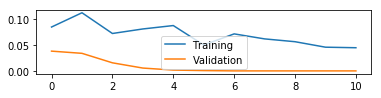

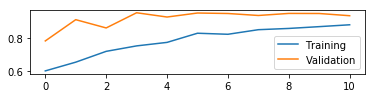

In [34]:
from addict import Dict
history = Dict(history.history)
plt.title("F1 Score")
plt.subplot(3,1,1)
plt.plot(history.f1)
plt.plot(history.val_f1)
plt.legend(["Training", "Validation"])
plt.show()

plt.subplot(3,1,2)
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.legend(["Training", "Validation"])
plt.show()



Let's try some random arrange

In [37]:
num_cnn_layers = 4
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer
x = tf.keras.layers.Reshape((1000,21))(x)

x = tf.keras.layers.Lambda(lambda x: tf.transpose(tf.random.shuffle(tf.transpose(x))), output_shape=(1000,21))(x)
x = tf.keras.layers.Reshape((1000,21, 1))(x)

for i in range(num_cnn_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.Conv2D(4, (3,3))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)

for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, name="seizure", activation="softmax")(x)
model = tf.keras.Model(inputs=inputLayer, outputs=x)

In [38]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy", f1, sensitivity, specificity])
batch_size=64
history = model.fit(train_data, steps_per_epoch=(600), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode="max", patience=10)])

Epoch 1/100
600/600 [==============================] - 73s 122ms/step - loss: 1.5851 - acc: 0.3586 - f1: 0.0652 - sensitivity: 0.2201 - specificity: 0.9630 - val_loss: 0.7406 - val_acc: 0.4771 - val_f1: 0.0480 - val_sensitivity: 0.1006 - val_specificity: 0.9569
Epoch 2/100
600/600 [==============================] - 60s 99ms/step - loss: 1.2798 - acc: 0.4299 - f1: 0.0479 - sensitivity: 0.2528 - specificity: 0.9730 - val_loss: 0.5130 - val_acc: 0.8552 - val_f1: 0.0329 - val_sensitivity: 0.0373 - val_specificity: 0.9638
Epoch 3/100
600/600 [==============================] - 60s 99ms/step - loss: 1.0192 - acc: 0.5183 - f1: 0.0548 - sensitivity: 0.2322 - specificity: 0.9712 - val_loss: 0.5321 - val_acc: 0.8223 - val_f1: 0.0508 - val_sensitivity: 0.0521 - val_specificity: 0.9248
Epoch 4/100
600/600 [==============================] - 60s 99ms/step - loss: 0.8361 - acc: 0.5959 - f1: 0.0698 - sensitivity: 0.1796 - specificity: 0.9591 - val_loss: 0.3766 - val_acc: 0.9534 - val_f1: 0.0035 - val_s

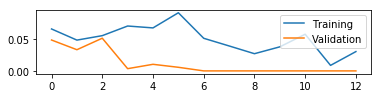

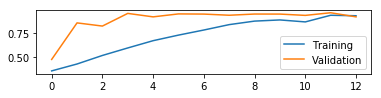

In [39]:
from addict import Dict
history = Dict(history.history)
plt.title("F1 Score")
plt.subplot(3,1,1)
plt.plot(history.f1)
plt.plot(history.val_f1)
plt.legend(["Training", "Validation"])
plt.show()

plt.subplot(3,1,2)
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.legend(["Training", "Validation"])
plt.show()



In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1000, 21)          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 1000, 21, 1)       0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1000, 21, 1)       4         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 998, 19, 4)        40        
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 998, 19, 4)        0         
__________

# Go multitask

In [6]:
def read_tfrecord(example):
    features = { \
               'data':  tf.io.FixedLenFeature([21*1000], tf.float32,),\
               'label':  tf.io.FixedLenFeature([1], tf.int64,),\
               'subtypeLabel':  tf.io.FixedLenFeature([1], tf.int64,),\
               'session':  tf.io.FixedLenFeature([1], tf.int64,), \
               'montage':  tf.io.FixedLenFeature([22], tf.int64,)}

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)

    # del example
    return data, (tf.one_hot(class_label[0], 2), tf.one_hot(example["subtypeLabel"][0], 4),  example["montage"], data)

In [13]:
num_cnn_layers = 3
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)

x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_decode])

In [7]:

def get_batched_dataset(filenames, batch_size, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_positive_train_dataset(filenames,  max_queue_size=5, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 1))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
   
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 0))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)   
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)

In [8]:
batch_size=64
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [82]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_v1_367 (Bat (None, 1000, 21, 1)  4           input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 1000, 21, 1)  10          batch_normalization_v1_367[0][0] 
__________________________________________________________________________________________________
leaky_re_lu_313 (LeakyReLU)     (None, 1000, 21, 1)  0           conv2d_120[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [ ]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"]})
batch_size=64
history = model.fit(train_data, steps_per_epoch=(600), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10)])

Epoch 1/100
600/600 [==============================] - 235s 392ms/step - loss: 233.2290 - detect_loss: 0.8793 - classify_loss: 1.9082 - montage_loss: 0.8166 - decode_loss: 229.6249 - detect_acc: 0.5825 - detect_f1: 0.5265 - detect_sensitivity: 0.4736 - detect_specificity: 0.5701 - classify_acc: 0.2454 - montage_binary_accuracy: 0.5390 - val_loss: 9727.1349 - val_detect_loss: 0.5636 - val_classify_loss: 1.3468 - val_montage_loss: 0.6233 - val_decode_loss: 9724.6025 - val_detect_acc: 0.7038 - val_detect_f1: 0.0495 - val_detect_sensitivity: 0.0942 - val_detect_specificity: 0.9379 - val_classify_acc: 0.5195 - val_montage_binary_accuracy: 0.6836
Epoch 2/100
600/600 [==============================] - 194s 324ms/step - loss: 195.4683 - detect_loss: 0.7522 - classify_loss: 1.6106 - montage_loss: 0.7551 - decode_loss: 192.3504 - detect_acc: 0.6524 - detect_f1: 0.6239 - detect_sensitivity: 0.5863 - detect_specificity: 0.6367 - classify_acc: 0.3295 - montage_binary_accuracy: 0.5751 - val_loss: 17

In [ ]:
import pickle as pkl
try:
    pkl.dump(history.history, open("/n/scratch2/ms994/history.pkl", "rb"))
except:
    print("whoops")

In [5]:
import pickle as pkl
history = pkl.load(open("/n/scratch2/ms994/history.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch2/ms994/history.pkl'

# try all the regularization! :D

In [10]:
num_cnn_layers = 3
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01))(x)

x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_decode])

In [11]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"]})
batch_size=64
history = model.fit(train_data, steps_per_epoch=(600), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10)])

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
600/600 [==============================] - 83s 139ms/step - loss: 243.5788 - detect_loss: 0.9359 - classify_loss: 1.7769 - montage_loss: 0.8351 - decode_loss: 227.0840 - detect_acc: 0.5849 - detect_f1: 0.5336 - detect_sensitivity: 0.4886 - detect_specificity: 0.5771 - classify_acc: 0.3046 - montage_binary_accuracy: 0.5220 - val_loss: 9739.1744 - val_detect_loss: 0.5855 - val_classify_loss: 0.9700 - val_montage_loss: 0.6061 - val_decode_loss: 9724.2422 - val_detect_acc: 0.6973 - val_detect_f1: 0.0497 - val_detect_sensitivity: 0.0863 - val_detect_specificity: 0.9388 - val_classify_acc: 0.6655 - val_montage_binary_accuracy: 0.7241
Epoch 2/100
600/600 [==============================] - 73s 122ms/step - loss: 208.0871 - detect_loss: 0.8182 - classify_loss: 1.5491 - montage_loss: 0.7832 - decode_loss: 192.3384 - detect_acc: 0.6397 - detect_f1: 0.6114 - detect_sensitivity: 0.5812 - detect_specificity: 0.6302 - classify_acc: 0.3881 - montage_binary_accuracy: 0.5526 - val_loss: 1737

KeyboardInterrupt: 

# Try removing regularization on CNN layers

In [14]:
num_cnn_layers = 3
num_lstm_layers = 2
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_decode])

In [16]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"]})
batch_size=128
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10)])

Epoch 1/100
400/400 [==============================] - 61s 152ms/step - loss: 239.3475 - detect_loss: 1.0249 - classify_loss: 1.8496 - montage_loss: 0.8623 - decode_loss: 222.7139 - detect_acc: 0.5598 - detect_f1: 0.6007 - detect_sensitivity: 0.6739 - detect_specificity: 0.5807 - classify_acc: 0.2831 - montage_binary_accuracy: 0.5113 - val_loss: 9739.6119 - val_detect_loss: 0.5643 - val_classify_loss: 1.1782 - val_montage_loss: 0.6640 - val_decode_loss: 9724.3984 - val_detect_acc: 0.6982 - val_detect_f1: 0.0508 - val_detect_sensitivity: 0.0849 - val_detect_specificity: 0.9517 - val_classify_acc: 0.5518 - val_montage_binary_accuracy: 0.6196
Epoch 2/100
400/400 [==============================] - 65s 162ms/step - loss: 245.4228 - detect_loss: 0.9186 - classify_loss: 1.7101 - montage_loss: 0.8260 - decode_loss: 229.2516 - detect_acc: 0.6019 - detect_f1: 0.6342 - detect_sensitivity: 0.7015 - detect_specificity: 0.6287 - classify_acc: 0.3366 - montage_binary_accuracy: 0.5285 - val_loss: 1737

In [20]:

history

{}

In [24]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_decode])

In [25]:
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"]})
batch_size=128
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10)])

Epoch 1/100
400/400 [==============================] - 62s 154ms/step - loss: 324.7246 - detect_loss: 1.0065 - classify_loss: 1.8519 - montage_loss: 0.8586 - decode_loss: 222.0489 - detect_acc: 0.5470 - detect_f1: 0.5302 - detect_sensitivity: 0.5166 - detect_specificity: 0.5434 - classify_acc: 0.2592 - montage_binary_accuracy: 0.5118 - val_loss: 9822.9542 - val_detect_loss: 0.4278 - val_classify_loss: 1.0551 - val_montage_loss: 0.6659 - val_decode_loss: 9724.1455 - val_detect_acc: 0.8403 - val_detect_f1: 0.0226 - val_detect_sensitivity: 0.0354 - val_detect_specificity: 0.9588 - val_classify_acc: 0.7629 - val_montage_binary_accuracy: 0.5826
Epoch 2/100
400/400 [==============================] - 54s 135ms/step - loss: 326.5561 - detect_loss: 0.9374 - classify_loss: 1.7659 - montage_loss: 0.8266 - decode_loss: 228.6016 - detect_acc: 0.5670 - detect_f1: 0.5503 - detect_sensitivity: 0.5364 - detect_specificity: 0.5633 - classify_acc: 0.2900 - montage_binary_accuracy: 0.5283 - val_loss: 1745

In [26]:
history = Dict(history.history)

In [27]:
history.keys()

dict_keys(['loss', 'detect_loss', 'classify_loss', 'montage_loss', 'decode_loss', 'detect_acc', 'detect_f1', 'detect_sensitivity', 'detect_specificity', 'classify_acc', 'montage_binary_accuracy', 'val_loss', 'val_detect_loss', 'val_classify_loss', 'val_montage_loss', 'val_decode_loss', 'val_detect_acc', 'val_detect_f1', 'val_detect_sensitivity', 'val_detect_specificity', 'val_classify_acc', 'val_montage_binary_accuracy'])

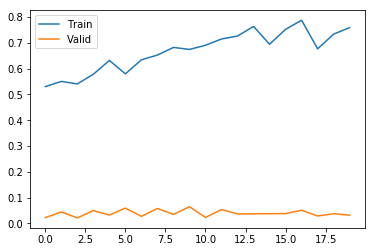

In [30]:
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.legend(["Train", "Valid"])

In [ ]:
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.legend(["Train", "Valid"])

# try multitask learning with session

In [20]:
def read_tfrecord(example):
    features = { \
               'data':  tf.io.FixedLenFeature([21*1000], tf.float32,),\
               'label':  tf.io.FixedLenFeature([1], tf.int64,),\
               'subtypeLabel':  tf.io.FixedLenFeature([1], tf.int64,),\
               'session':  tf.io.FixedLenFeature([1], tf.int64,), \
               'montage':  tf.io.FixedLenFeature([22], tf.int64,)}

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)

    # del example
    return data, (tf.one_hot(class_label[0], 2), tf.one_hot(example["subtypeLabel"][0], 4),  example["montage"], tf.one_hot(example["session"][0], 575), data)

def get_batched_dataset(filenames, batch_size, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_positive_train_dataset(filenames,  max_queue_size=5, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 1))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
   
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 0))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)   
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)

## session multitask learning

In [3]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(10)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


W0330 23:21:51.713369 140287959897920 deprecation.py:506] From /home/ms994/miniconda3/envs/keras-v2/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


AttributeError: module 'tensorflow_core.keras.layers' has no attribute 'CuDNNLSTM'

In [ ]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10)])

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
400/400 [==============================] - 126s 316ms/step - loss: 336.0696 - detect_loss: 0.9859 - classify_loss: 1.8558 - montage_loss: 0.8382 - patient_loss: 6.4759 - decode_loss: 226.9110 - detect_acc: 0.5143 - detect_f1: 0.5206 - detect_sensitivity: 0.5297 - detect_specificity: 0.5134 - classify_acc: 0.2649 - montage_binary_accuracy: 0.5181 - patient_acc: 0.0020 - val_loss: 13646.1721 - val_detect_loss: 0.3810 - val_classify_loss: 0.9039 - val_montage_loss: 0.6159 - val_patient_loss: 6.3608 - val_decode_loss: 13541.2959 - val_detect_acc: 0.9138 - val_detect_f1: 0.0188 - val_detect_sensitivity: 0.0283 - val_detect_specificity: 0.9627 - val_classify_acc: 0.8432 - val_montage_binary_accuracy: 0.7267 - val_patient_acc: 4.9479e-04
Epoch 2/100
400/400 [==============================] - 117s 292ms/step - loss: 299.8096 - detect_loss: 0.9170 - classify_loss: 1.7228 - montage_loss: 0.8059 - patient_loss: 6.4336 - decode_loss: 195.6473 - detect_acc: 0.5347 - detect_f1: 0.5350 - 

Epoch 12/100
400/400 [==============================] - 127s 317ms/step - loss: 256.6632 - detect_loss: 0.6158 - classify_loss: 1.0641 - montage_loss: 0.5579 - patient_loss: 6.1497 - decode_loss: 193.4266 - detect_acc: 0.7312 - detect_f1: 0.7290 - detect_sensitivity: 0.7215 - detect_specificity: 0.7236 - classify_acc: 0.5533 - montage_binary_accuracy: 0.7210 - patient_acc: 0.0106 - val_loss: 13314.2102 - val_detect_loss: 0.3734 - val_classify_loss: 0.3735 - val_montage_loss: 0.1631 - val_patient_loss: 6.3853 - val_decode_loss: 13253.7100 - val_detect_acc: 0.8786 - val_detect_f1: 0.0370 - val_detect_sensitivity: 0.0459 - val_detect_specificity: 0.9363 - val_classify_acc: 0.8963 - val_montage_binary_accuracy: 0.9331 - val_patient_acc: 6.5104e-04
Epoch 13/100
400/400 [==============================] - 120s 299ms/step - loss: 255.4974 - detect_loss: 0.5441 - classify_loss: 0.9893 - montage_loss: 0.5414 - patient_loss: 6.1389 - decode_loss: 195.6887 - detect_acc: 0.7565 - detect_f1: 0.7556 

Epoch 23/100
400/400 [==============================] - 118s 294ms/step - loss: 225.9492 - detect_loss: 0.5449 - classify_loss: 0.8954 - montage_loss: 0.4834 - patient_loss: 5.8232 - decode_loss: 192.6586 - detect_acc: 0.7751 - detect_f1: 0.7725 - detect_sensitivity: 0.7685 - detect_specificity: 0.7713 - classify_acc: 0.6173 - montage_binary_accuracy: 0.7658 - patient_acc: 0.0191 - val_loss: 14224.3943 - val_detect_loss: 0.4654 - val_classify_loss: 0.4877 - val_montage_loss: 0.1795 - val_patient_loss: 6.4308 - val_decode_loss: 14192.2920 - val_detect_acc: 0.8459 - val_detect_f1: 0.0556 - val_detect_sensitivity: 0.0661 - val_detect_specificity: 0.9373 - val_classify_acc: 0.8573 - val_montage_binary_accuracy: 0.9343 - val_patient_acc: 1.3021e-04
Epoch 24/100
400/400 [==============================] - 122s 306ms/step - loss: 199.7537 - detect_loss: 0.5436 - classify_loss: 0.9131 - montage_loss: 0.4770 - patient_loss: 5.7564 - decode_loss: 168.4770 - detect_acc: 0.7671 - detect_f1: 0.7642 

In [42]:
history = Dict(history.history)

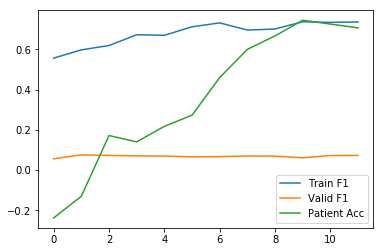

In [47]:
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

# Try to remove the l1/l2 regularization and see effect on patient acc

In [48]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2**(2-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


In [49]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10, verbose=True)])

Epoch 1/100
400/400 [==============================] - 139s 347ms/step - loss: 236.7190 - detect_loss: 0.9920 - classify_loss: 2.0229 - montage_loss: 0.8937 - patient_loss: 6.4789 - decode_loss: 226.3316 - detect_acc: 0.5445 - detect_f1: 0.4998 - detect_sensitivity: 0.4568 - detect_specificity: 0.5364 - classify_acc: 0.2459 - montage_binary_accuracy: 0.4826 - patient_acc: 0.0022 - val_loss: 13549.6912 - val_detect_loss: 0.5154 - val_classify_loss: 1.1861 - val_montage_loss: 0.6939 - val_patient_loss: 6.3630 - val_decode_loss: 13540.9297 - val_detect_acc: 0.6956 - val_detect_f1: 0.0603 - val_detect_sensitivity: 0.1052 - val_detect_specificity: 0.9716 - val_classify_acc: 0.6439 - val_montage_binary_accuracy: 0.5268 - val_patient_acc: 0.0010
Epoch 2/100
400/400 [==============================] - 137s 341ms/step - loss: 204.9252 - detect_loss: 0.8752 - classify_loss: 1.7950 - montage_loss: 0.8532 - patient_loss: 6.4502 - decode_loss: 194.9516 - detect_acc: 0.5957 - detect_f1: 0.5673 - dete

Epoch 12/100
400/400 [==============================] - 141s 352ms/step - loss: 205.1951 - detect_loss: 0.5728 - classify_loss: 1.0513 - montage_loss: 0.5799 - patient_loss: 6.1310 - decode_loss: 196.8601 - detect_acc: 0.7600 - detect_f1: 0.7625 - detect_sensitivity: 0.7693 - detect_specificity: 0.7617 - classify_acc: 0.5839 - montage_binary_accuracy: 0.6936 - patient_acc: 0.0126 - val_loss: 13252.5506 - val_detect_loss: 0.5640 - val_classify_loss: 0.5722 - val_montage_loss: 0.3129 - val_patient_loss: 6.3620 - val_decode_loss: 13244.7344 - val_detect_acc: 0.7327 - val_detect_f1: 0.0757 - val_detect_sensitivity: 0.1095 - val_detect_specificity: 0.9116 - val_classify_acc: 0.8013 - val_montage_binary_accuracy: 0.8781 - val_patient_acc: 2.3437e-04
Epoch 13/100
400/400 [==============================] - 139s 347ms/step - loss: 201.7252 - detect_loss: 0.4779 - classify_loss: 0.9464 - montage_loss: 0.5542 - patient_loss: 6.1457 - decode_loss: 193.6011 - detect_acc: 0.7941 - detect_f1: 0.7960 

In [51]:
history = Dict(history.history)

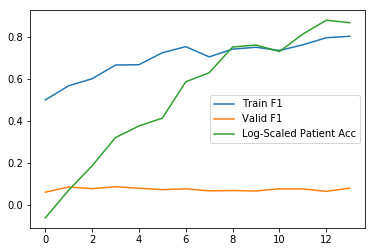

In [52]:
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

# Try multitask learning with session and higher lr

In [ ]:
from tensorflow import control_flow_ops

In [60]:
control_flow_opts

NameError: name 'control_flow_opts' is not defined

In [4]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [23]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", auc, f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

In [24]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [8]:
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10, verbose=True)])

Epoch 1/100
400/400 [==============================] - 70s 175ms/step - loss: 233.3886 - detect_loss: 0.7621 - classify_loss: 1.2865 - montage_loss: 0.7050 - patient_loss: 6.3680 - decode_loss: 224.2671 - detect_acc: 0.6371 - detect_auc: 0.6416 - detect_f1: 0.6463 - detect_sensitivity: 0.6627 - detect_specificity: 0.6408 - classify_acc: 0.4717 - montage_binary_accuracy: 0.6032 - patient_acc: 0.0052 - val_loss: 13546.7966 - val_detect_loss: 0.4367 - val_classify_loss: 0.5574 - val_montage_loss: 0.2933 - val_patient_loss: 6.3778 - val_decode_loss: 13539.1279 - val_detect_acc: 0.7797 - val_detect_auc: 0.7701 - val_detect_f1: 0.0571 - val_detect_sensitivity: 0.0827 - val_detect_specificity: 0.9715 - val_classify_acc: 0.8021 - val_montage_binary_accuracy: 0.8682 - val_patient_acc: 2.0833e-04
Epoch 2/100
400/400 [==============================] - 43s 109ms/step - loss: 185.7047 - detect_loss: 0.6590 - classify_loss: 1.0491 - montage_loss: 0.5515 - patient_loss: 5.9828 - decode_loss: 177.4622

In [9]:
history = Dict(history.history)

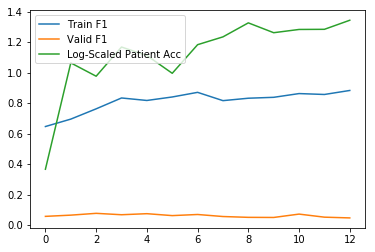

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

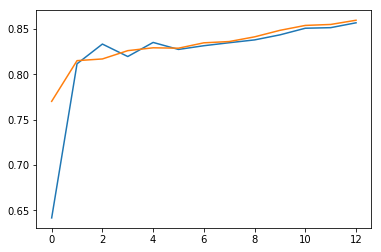

In [12]:
plt.plot(history.detect_auc)
plt.plot(history.val_detect_auc)

# try increasing gaussian noise

In [8]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    tf.keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

In [9]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(10)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", auc, f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

In [10]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [11]:
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10, verbose=True)])

Epoch 1/100
400/400 [==============================] - 117s 292ms/step - loss: 227.8837 - detect_loss: 0.6857 - classify_loss: 1.2841 - montage_loss: 0.6994 - patient_loss: 6.4035 - decode_loss: 218.8109 - detect_acc: 0.6725 - detect_auc: 0.6558 - detect_f1: 0.6618 - detect_sensitivity: 0.6499 - detect_specificity: 0.6680 - classify_acc: 0.4753 - montage_binary_accuracy: 0.6147 - patient_acc: 0.0032 - val_loss: 13543.3041 - val_detect_loss: 0.3510 - val_classify_loss: 0.4624 - val_montage_loss: 0.1882 - val_patient_loss: 6.3846 - val_decode_loss: 13535.9180 - val_detect_acc: 0.8767 - val_detect_auc: 0.8347 - val_detect_f1: 0.0417 - val_detect_sensitivity: 0.0476 - val_detect_specificity: 0.9681 - val_classify_acc: 0.8679 - val_montage_binary_accuracy: 0.9242 - val_patient_acc: 2.6042e-05
Epoch 2/100
400/400 [==============================] - 86s 215ms/step - loss: 179.1062 - detect_loss: 0.6127 - classify_loss: 1.0315 - montage_loss: 0.5494 - patient_loss: 6.0178 - decode_loss: 170.894

400/400 [==============================] - 92s 230ms/step - loss: 71.7082 - detect_loss: 0.3867 - classify_loss: 0.6233 - montage_loss: 0.4008 - patient_loss: 5.2981 - decode_loss: 64.9993 - detect_acc: 0.8462 - detect_auc: 0.9074 - detect_f1: 0.8477 - detect_sensitivity: 0.8447 - detect_specificity: 0.8398 - classify_acc: 0.7299 - montage_binary_accuracy: 0.8080 - patient_acc: 0.0373 - val_loss: 14021.9567 - val_detect_loss: 0.3969 - val_classify_loss: 0.4830 - val_montage_loss: 0.1685 - val_patient_loss: 7.0250 - val_decode_loss: 14013.8848 - val_detect_acc: 0.8367 - val_detect_auc: 0.9068 - val_detect_f1: 0.0429 - val_detect_sensitivity: 0.0472 - val_detect_specificity: 0.9472 - val_classify_acc: 0.8269 - val_montage_binary_accuracy: 0.9556 - val_patient_acc: 1.4323e-04
Epoch 22/100
400/400 [==============================] - 90s 224ms/step - loss: 65.7011 - detect_loss: 0.2855 - classify_loss: 0.5320 - montage_loss: 0.3729 - patient_loss: 5.0915 - decode_loss: 59.4192 - detect_acc: 

In [12]:
history = Dict(history.history)

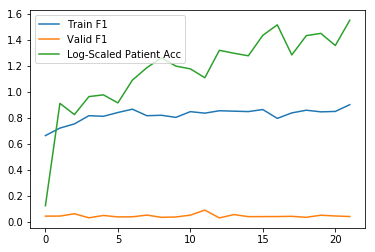

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

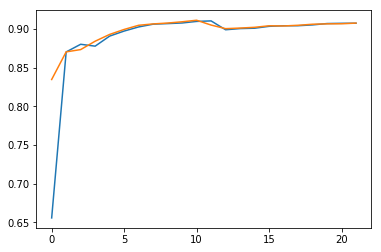

In [14]:
plt.plot(history.detect_auc)
plt.plot(history.val_detect_auc)

# try randomly rearranging channels, even though montage accuracy will suffer

In [24]:
def read_tfrecord(example):
    features = { \
               'data':  tf.io.FixedLenFeature([21*1000], tf.float32,),\
               'label':  tf.io.FixedLenFeature([1], tf.int64,),\
               'subtypeLabel':  tf.io.FixedLenFeature([1], tf.int64,),\
               'session':  tf.io.FixedLenFeature([1], tf.int64,), \
               'montage':  tf.io.FixedLenFeature([22], tf.int64,)}

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [1000,21])
    data = tf.transpose(tf.random.shuffle(tf.transpose(data)))
    data = tf.reshape(data, [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)

    # del example
    return data, (tf.one_hot(class_label[0], 2), tf.one_hot(example["subtypeLabel"][0], 4),  example["montage"], tf.one_hot(example["session"][0], 575), data)

def get_batched_dataset(filenames, batch_size, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_positive_train_dataset(filenames,  max_queue_size=5, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 1))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
   
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 0))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)   
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)

In [21]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(10)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", auc, f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

In [25]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [26]:
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10, verbose=True)])

Epoch 1/100
400/400 [==============================] - 121s 302ms/step - loss: 232.1201 - detect_loss: 0.7610 - classify_loss: 1.3218 - montage_loss: 0.6874 - patient_loss: 6.3275 - decode_loss: 223.0224 - detect_acc: 0.6304 - detect_auc: 0.6133 - detect_f1: 0.6350 - detect_sensitivity: 0.6500 - detect_specificity: 0.6380 - classify_acc: 0.4625 - montage_binary_accuracy: 0.6142 - patient_acc: 0.0053 - val_loss: 13543.2780 - val_detect_loss: 0.3570 - val_classify_loss: 0.4677 - val_montage_loss: 0.2255 - val_patient_loss: 6.3844 - val_decode_loss: 13535.8438 - val_detect_acc: 0.8286 - val_detect_auc: 0.7733 - val_detect_f1: 0.0476 - val_detect_sensitivity: 0.0739 - val_detect_specificity: 0.9717 - val_classify_acc: 0.8450 - val_montage_binary_accuracy: 0.9003 - val_patient_acc: 7.8125e-05
Epoch 2/100
400/400 [==============================] - 114s 286ms/step - loss: 184.8003 - detect_loss: 0.6788 - classify_loss: 1.0900 - montage_loss: 0.5699 - patient_loss: 6.0045 - decode_loss: 176.45

In [27]:
history = Dict(history.history)

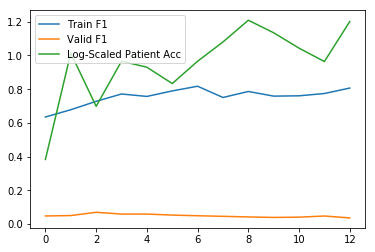

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

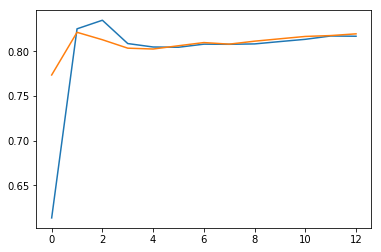

In [29]:
plt.plot(history.detect_auc)
plt.plot(history.val_detect_auc)

# Try less noise but still keep random rearrange

In [30]:
def read_tfrecord(example):
    features = { \
               'data':  tf.io.FixedLenFeature([21*1000], tf.float32,),\
               'label':  tf.io.FixedLenFeature([1], tf.int64,),\
               'subtypeLabel':  tf.io.FixedLenFeature([1], tf.int64,),\
               'session':  tf.io.FixedLenFeature([1], tf.int64,), \
               'montage':  tf.io.FixedLenFeature([22], tf.int64,)}

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [1000,21])
    data = tf.transpose(tf.random.shuffle(tf.transpose(data)))
    data = tf.reshape(data, [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)

    # del example
    return data, (tf.one_hot(class_label[0], 2), tf.one_hot(example["subtypeLabel"][0], 4),  example["montage"], tf.one_hot(example["session"][0], 575), data)

def get_batched_dataset(filenames, batch_size, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_positive_train_dataset(filenames,  max_queue_size=5, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 1))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
#     
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
   
    
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(y[0], 0), 0))

    
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)   
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)

In [32]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(5)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", auc, f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})
batch_size=128


In [33]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [34]:
batch_size=128
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
train_unbalanced = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size, is_train=False)

In [35]:
history = model.fit(train_data, steps_per_epoch=(400), validation_data=valid_data, validation_steps=(600), epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_detect_f1", mode="max", patience=10, verbose=True)])

Epoch 1/100
400/400 [==============================] - 180s 451ms/step - loss: 231.8195 - detect_loss: 0.7563 - classify_loss: 1.3749 - montage_loss: 0.7240 - patient_loss: 6.3912 - decode_loss: 222.5733 - detect_acc: 0.6472 - detect_auc: 0.6356 - detect_f1: 0.6621 - detect_sensitivity: 0.6892 - detect_specificity: 0.6547 - classify_acc: 0.4314 - montage_binary_accuracy: 0.5934 - patient_acc: 0.0044 - val_loss: 13543.5105 - val_detect_loss: 0.4376 - val_classify_loss: 0.6768 - val_montage_loss: 0.3264 - val_patient_loss: 6.3951 - val_decode_loss: 13535.6729 - val_detect_acc: 0.7971 - val_detect_auc: 0.7653 - val_detect_f1: 0.0422 - val_detect_sensitivity: 0.0708 - val_detect_specificity: 0.9671 - val_classify_acc: 0.7558 - val_montage_binary_accuracy: 0.8646 - val_patient_acc: 2.7344e-04
Epoch 2/100
400/400 [==============================] - 134s 335ms/step - loss: 181.6173 - detect_loss: 0.6475 - classify_loss: 1.0916 - montage_loss: 0.5800 - patient_loss: 6.0530 - decode_loss: 173.24

400/400 [==============================] - 124s 309ms/step - loss: 72.1260 - detect_loss: 0.4421 - classify_loss: 0.7248 - montage_loss: 0.4381 - patient_loss: 5.5385 - decode_loss: 64.9825 - detect_acc: 0.8227 - detect_auc: 0.8431 - detect_f1: 0.8225 - detect_sensitivity: 0.8233 - detect_specificity: 0.8224 - classify_acc: 0.6603 - montage_binary_accuracy: 0.7785 - patient_acc: 0.0197 - val_loss: 13721.4655 - val_detect_loss: 0.5507 - val_classify_loss: 0.5795 - val_montage_loss: 0.2152 - val_patient_loss: 6.8220 - val_decode_loss: 13713.2959 - val_detect_acc: 0.7263 - val_detect_auc: 0.8422 - val_detect_f1: 0.0672 - val_detect_sensitivity: 0.0999 - val_detect_specificity: 0.9409 - val_classify_acc: 0.7586 - val_montage_binary_accuracy: 0.9424 - val_patient_acc: 1.3021e-05
Epoch 22/100
400/400 [==============================] - 122s 305ms/step - loss: 63.7482 - detect_loss: 0.3367 - classify_loss: 0.6300 - montage_loss: 0.4183 - patient_loss: 5.3967 - decode_loss: 56.9666 - detect_acc

In [36]:
history = Dict(history.history)

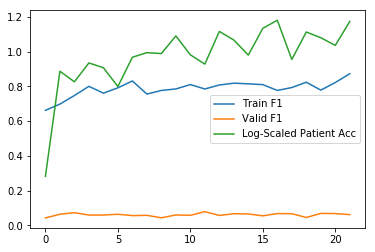

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.detect_f1)
plt.plot(history.val_detect_f1)
plt.plot((np.log(history.patient_acc) + 6)/2 )
plt.legend(["Train F1", "Valid F1", "Log-Scaled Patient Acc"])

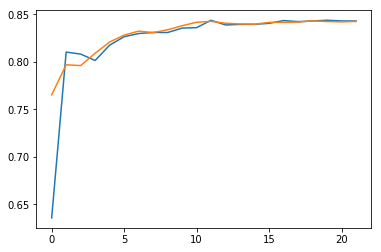

In [38]:
plt.plot(history.detect_auc)
plt.plot(history.val_detect_auc)

# Make one of the outputs (session identification) adversarial

In [26]:
num_cnn_layers = 3
num_lstm_layers = 1
num_lin_layers= 4
inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(2)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

#session measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)

#decoder
x = x_shared
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2, (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, x_patient, x_decode])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss_weights=[1,1,1,-1,1], loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", "categorical_crossentropy", "mean_squared_error"], metrics={"detect":["accuracy", auc, f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], "patient": ["accuracy"]})


#adversarial patient measurement
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x_pre_patient = x
x_patient = tf.keras.layers.Dense(575, name="patient", activation="softmax")(x)
patient_model = tf.keras.Model(inputs=inputLayer, outputs=x_patient)
patient_model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

#seizure only model
seizure_model = tf.keras.Model()

In [27]:
train_iterator = train_unbalanced.make_one_shot_iterator()

In [28]:
oldPatientWeights = patient_model.layers[-1].get_weights()
oldNonPatientWeights = [layer.get_weights() for layer in seizure_model.layers[:-1]]

for epochs in range(1):
    for batch in range(4):
        toTrainOn = train_iterator.get_next()
        
        #old patient weights are trying to predict for patient, try to do the prediction!
        patient_model.layers[-1].set_weights(oldPatientWeights)
        #keep the other nonpatient weights which try not to predict for patient!
        oldNonPatientWeights = [layer.get_weights() for layer in seizure_model.layers[:-1]]
        patient_model.train_on_batch(train_batch[0], train_batch[1][1])
#         patient_accs_epoch.append(patient_acc)
        #get weights that try to predict for patient
        oldPatientWeights = patient_model.layers[-1].get_weights()

(<tf.Tensor 'IteratorGetNext_4:0' shape=(128, 1000, 21, 1) dtype=float32>,
 (<tf.Tensor 'IteratorGetNext_4:1' shape=(128, 2) dtype=float32>,
  <tf.Tensor 'IteratorGetNext_4:2' shape=(128, 4) dtype=float32>,
  <tf.Tensor 'IteratorGetNext_4:3' shape=(128, 22) dtype=int64>,
  <tf.Tensor 'IteratorGetNext_4:4' shape=(128, 575) dtype=float32>,
  <tf.Tensor 'IteratorGetNext_4:5' shape=(128, 1000, 21, 1) dtype=float32>))